In [1]:
!pip install langchain langchain_core langchain_community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 7.9 MB/s eta 0:00:00


In [2]:
pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')

In [17]:
import operator
from typing import Annotated, TypedDict
from langchain_core.pydantic_v1 import BaseModel
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START
from langchain_groq import ChatGroq

model=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-70b-8192")


In [18]:
# Define the prompts
step1_prompt = """Step 1: I have a problem related to {input}.
Could you brainstorm three distinct solutions?
Please consider a variety of factors such as {perfect_factors}"""

step2_prompt = """Step 2: For each of the three proposed solutions, evaluate their potential.
Consider their pros and cons, initial effort needed, implementation difficulty, potential challenges,
and the expected outcomes. Assign a probability of success and a confidence level
to each option based on these factors.

Solutions:
{solutions}"""

step3_prompt = """Step 3: For each solution, deepen the thought process.
Generate potential scenarios, strategies for implementation, any necessary partnerships or resources,
and how potential obstacles might be overcome. Also, consider any potential unexpected outcomes
and how they might be handled.

Evaluation:
{review}"""

step4_prompt = """Step 4: Based on the evaluations and scenarios,
rank the solutions in order of promise. Provide a justification for each ranking
and offer any final thoughts or considerations for each solution.

Detailed analysis:
{deepen_thought_process}"""

In [19]:
# Define the output structures
class Solutions(BaseModel):
    solutions: list[str]

class Review(BaseModel):
    review: str

class DeepThought(BaseModel):
    deep_thought: str

class RankedSolutions(BaseModel):
    ranked_solutions: str

# Define the overall state
class OverallState(TypedDict):
    input: str
    perfect_factors: str
    solutions: Annotated[list[str], operator.add]
    reviews: Annotated[list[str], operator.add]
    deep_thoughts: Annotated[list[str], operator.add]
    ranked_solutions: dict

# Define the state for individual solution processing
class SolutionState(TypedDict):
    solution: str

In [20]:
# Graph components
def generate_solutions(state: OverallState):
    prompt = step1_prompt.format(input=state["input"], perfect_factors=state["perfect_factors"])
    response = model.with_structured_output(Solutions).invoke(prompt)
    return {"solutions": response.solutions}

def evaluate_solution(state: SolutionState):
    prompt = step2_prompt.format(solutions=state["solution"])
    response = model.with_structured_output(Review).invoke(prompt)
    return {"reviews": [response.review]}

def deepen_thought(state: SolutionState):
    prompt = step3_prompt.format(review=state["solution"])
    response = model.with_structured_output(DeepThought).invoke(prompt)
    return {"deep_thoughts": [response.deep_thought]}

def rank_solutions(state: OverallState):
    deep_thoughts = "\n\n".join(state["deep_thoughts"])
    prompt = step4_prompt.format(deepen_thought_process=deep_thoughts)
    response = model.with_structured_output(RankedSolutions).invoke(prompt)
    return {"ranked_solutions": response.ranked_solutions}

# Define the mapping logic
def continue_to_evaluation(state: OverallState):
    return [Send("evaluate_solution", {"solution": s}) for s in state["solutions"]]

def continue_to_deep_thought(state: OverallState):
    return [Send("deepen_thought", {"solution": r}) for r in state["reviews"]]

In [21]:
# Construct the graph
graph = StateGraph(OverallState)

graph.add_node("generate_solutions", generate_solutions)
graph.add_node("evaluate_solution", evaluate_solution)
graph.add_node("deepen_thought", deepen_thought)
graph.add_node("rank_solutions", rank_solutions)

graph.add_edge(START, "generate_solutions")
graph.add_conditional_edges("generate_solutions", continue_to_evaluation, ["evaluate_solution"])
graph.add_conditional_edges("evaluate_solution", continue_to_deep_thought, ["deepen_thought"])
graph.add_edge("deepen_thought", "rank_solutions")
graph.add_edge("rank_solutions", END)

In [22]:
app = graph.compile()

In [23]:
# Call the graph
for s in app.stream({
    "input": "improving public transportation in a growing city",
    "perfect_factors": "cost, efficiency, environmental impact, and user experience"
}):
    print(s)

{'generate_solutions': {'solutions': ['Increase bus frequency', 'Implement smart traffic lights', 'Develop bike-sharing system']}}
{'evaluate_solution': {'reviews': ['Evaluating the potential of increasing bus frequency as a solution']}}
{'evaluate_solution': {'reviews': ['Evaluating the potential of implementing smart traffic lights']}}
{'evaluate_solution': {'reviews': ['Evaluate the potential of developing a bike-sharing system']}}
{'deepen_thought': {'deep_thoughts': ['Deepen the thought process on evaluating the potential of implementing smart traffic lights']}}
{'deepen_thought': {'deep_thoughts': ['Evaluate the potential of increasing bus frequency as a solution']}}
{'deepen_thought': {'deep_thoughts': ['Evaluate the potential of developing a bike-sharing system']}}
{'rank_solutions': {'ranked_solutions': 'bus_frequency,smart_traffic_lights,bike_sharing_system'}}


In [24]:
from pprint import pprint
pprint(s)

{'rank_solutions': {'ranked_solutions': 'bus_frequency,smart_traffic_lights,bike_sharing_system'}}


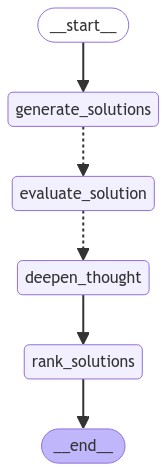

In [25]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())
